In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import h5py as h5
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from config.path import VERVET_DATA
import glob


In [ ]:
# Get all the file paths for FOM and Transmittance data


fom_data = list(glob.glob(f"{VERVET_DATA}/*{"FOM_HSV"}.h5"))
trans_data = list(glob.glob(f"{VERVET_DATA}/*{"Ntransmittance"}.h5"))


print(len(trans_data))
# Load the first Transmittance data file
sample_trans_data = h5.File(trans_data[0], 'r')

4


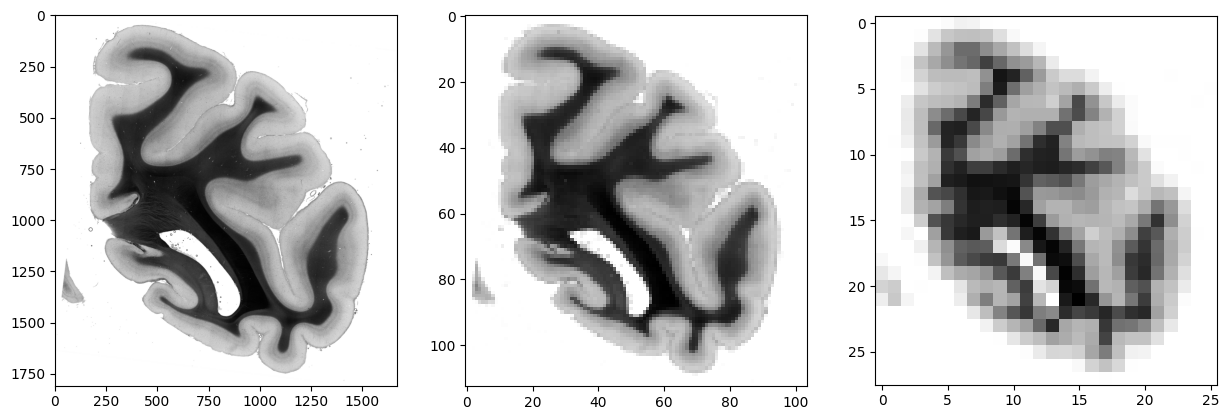

In [6]:
# fix show 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# The HDF5 group pyramid consists of datasets 00. . . 10. Each of these datasets is a
# downsampled version of the original image by a factor of 2n

resolutions = ["04", "08", "10"]
for i, ax in enumerate(ax):
    ax.imshow(sample_trans_data["pyramid"][resolutions[i]], cmap='gray')


# 1 B

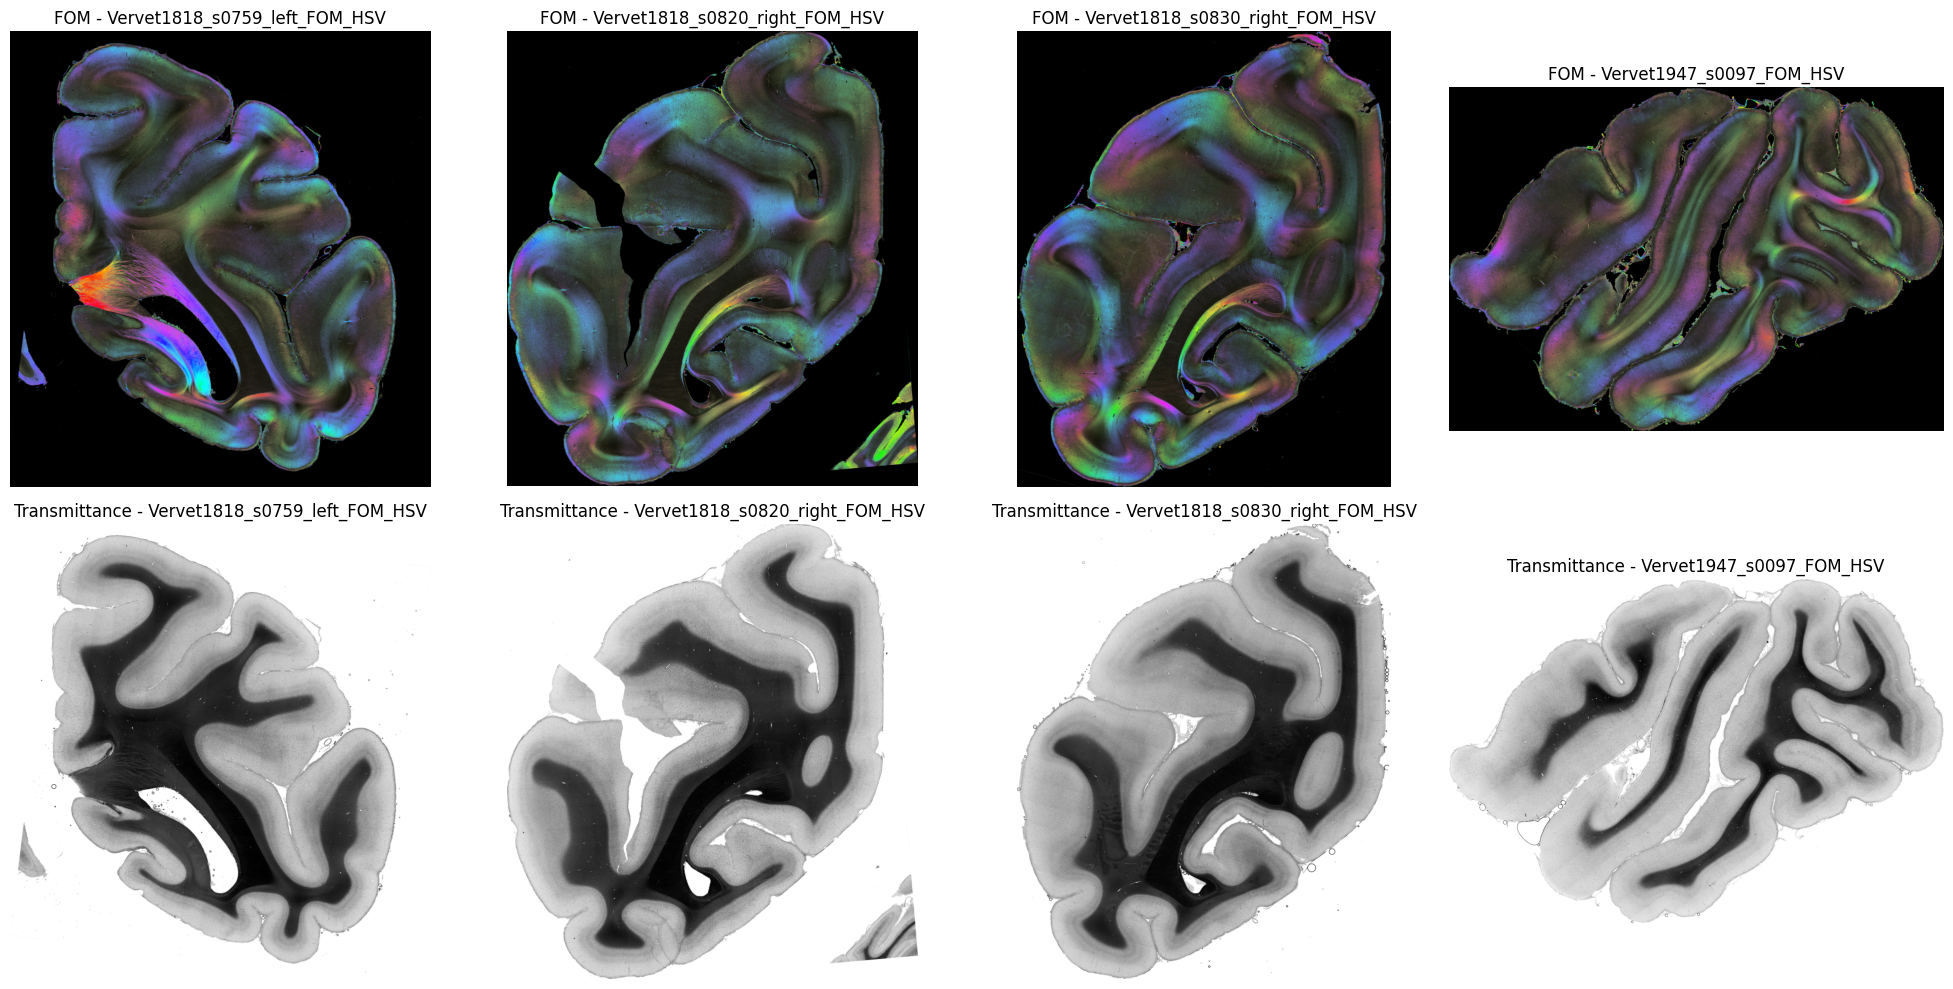

In [7]:
import h5py as h5
import matplotlib.pyplot as plt
from pathlib import Path



def load_hdf5_file(file_path):
    """Load an HDF5 file and return the file object."""
    return h5.File(file_path, 'r')

def visualize_images(fom_images, trans_images, titles, cmap='gray'):
    n_cols = len(fom_images)
    fig, axs = plt.subplots(2, n_cols, figsize=(5*n_cols, 10))
    
    # Handle the case where there's only one column
    if n_cols == 1:
        axs = axs.reshape(-1, 1)
    
    # Plot FOM images in the first row
    for i in range(n_cols):
        axs[0, i].imshow(fom_images[i], cmap=cmap)
        axs[0, i].set_title(f"FOM - {titles[i]}")
        axs[0, i].axis('off')
    
    # Plot Transmittance images in the second row
    for i in range(n_cols):
        axs[1, i].imshow(trans_images[i], cmap=cmap)
        axs[1, i].set_title(f"Transmittance - {titles[i]}")
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_pyramid_level(fom_paths, trans_paths, pyramid_level="05"):
    
    fom_images = []
    trans_images = []
    titles = []
    
    for fom_path, trans_path in zip(fom_paths, trans_paths):
        # Convert to Path objects if they aren't already
        fom_path = Path(fom_path)
        trans_path = Path(trans_path)
        
        # Load and convert HDF5 data to numpy arrays
        with h5.File(fom_path, 'r') as fom_data, h5.File(trans_path, 'r') as trans_data:
            # Convert to numpy arrays immediately after reading
            fom_img = np.array(fom_data["pyramid"][pyramid_level])
            trans_img = np.array(trans_data["pyramid"][pyramid_level])
            
            fom_images.append(fom_img)
            trans_images.append(trans_img)
            titles.append(fom_path.stem)  # Using stem instead of name to remove extension
    
    visualize_images(fom_images, trans_images, titles)

def visualize_all_images(fom_paths, trans_paths, pyramid_level="05"):
    # Ensure inputs are lists
    if not isinstance(fom_paths, (list, tuple)):
        fom_paths = [fom_paths]
    if not isinstance(trans_paths, (list, tuple)):
        trans_paths = [trans_paths]
        
    visualize_pyramid_level(fom_paths, trans_paths, pyramid_level)



# Visualize all images
visualize_all_images(fom_data, trans_data)

# 1 C

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, interactive_output
import ipywidgets as widgets
from IPython.display import display, clear_output

def explore_and_crop(fom_path, trans_path, pyramid_level="05"):
    """
    Interactive exploration of sections using sliders in Jupyter notebook.
    """
    with h5.File(fom_path, 'r') as fom_f, h5.File(trans_path, 'r') as trans_f:
        # Load lower resolution versions for navigation
        fom = np.array(fom_f['pyramid'][pyramid_level])
        trans = np.array(trans_f['pyramid'][pyramid_level])
        
        # Calculate scale factor
        scale = 2**int(pyramid_level)
        
        def update_view(y_center, x_center, window_size):
            # Clear previous output
            clear_output(wait=True)
            
            # Create new figure
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
            
            # Show full images with rectangle showing current region
            ax1.imshow(fom)
            ax2.imshow(trans, cmap='gray')
            
            # Calculate rectangle coordinates (scaled for pyramid level)
            half_win = window_size // (2 * scale)
            rect1 = plt.Rectangle((x_center-half_win, y_center-half_win), 
                                half_win*2, half_win*2, 
                                fill=False, color='red', linewidth=2)
            rect2 = plt.Rectangle((x_center-half_win, y_center-half_win), 
                                half_win*2, half_win*2, 
                                fill=False, color='red', linewidth=2)
            
            ax1.add_patch(rect1)
            ax2.add_patch(rect2)
            
            # Calculate full resolution coordinates
            full_y = y_center * scale
            full_x = x_center * scale
            crop_coords = (
                max(0, full_y - window_size//2),
                max(0, full_y + window_size//2),
                max(0, full_x - window_size//2),
                max(0, full_x + window_size//2)
            )
            
            ax1.set_title(f"FOM - Full res crop coordinates:\n{crop_coords}")
            ax2.set_title("Transmittance")
            
            plt.tight_layout()
            plt.show()
            
            print(f"Full resolution crop coordinates: {crop_coords}")
            print(f"Window size: {window_size}x{window_size} pixels")
            return crop_coords
        
        # Create sliders
        y_slider = widgets.IntSlider(
            min=0,
            max=fom.shape[0]-1,
            step=10,
            description='Y position:',
            continuous_update=False,
            style={'description_width': 'initial'}
        )
        
        x_slider = widgets.IntSlider(
            min=0,
            max=fom.shape[1]-1,
            step=10,
            description='X position:',
            continuous_update=False,
            style={'description_width': 'initial'}
        )
        
        window_slider = widgets.IntSlider(
            min=64,
            max=8192,
            step=64,
            value=256,
            description='Window size:',
            continuous_update=False,
            style={'description_width': 'initial'}
        )
        
        # Create widget layout
        widgets_dict = {
            'y_center': y_slider,
            'x_center': x_slider,
            'window_size': window_slider
        }
        
        # Create interactive output
        out = interactive_output(update_view, widgets_dict)
        
        # Display widgets and output
        display(widgets.VBox([y_slider, x_slider, window_slider, out]))

def view_crop(fom_path, trans_path, coords):
    """
    View a specific crop from both FOM and transmittance maps.
    coords: tuple of (start_y, end_y, start_x, end_x)
    """
    with h5.File(fom_path, 'r') as fom_f, h5.File(trans_path, 'r') as trans_f:
        # Get crops
        fom_crop = fom_f['Image'][coords[0]:coords[1], coords[2]:coords[3]]
        trans_crop = trans_f['Image'][coords[0]:coords[1], coords[2]:coords[3]]
        
        # Display crops
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(fom_crop)
        ax1.set_title(f"FOM Crop at {coords}")
        ax1.axis('off')
        
        ax2.imshow(trans_crop, cmap='gray')
        ax2.set_title(f"Transmittance Crop")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

fom_file = VERVET_DATA / "Vervet1818_s0820_right_FOM_HSV.h5"
trans_file = VERVET_DATA / "Vervet1818_s0820_right_NTransmittance.h5"

explore_and_crop(fom_file, trans_file)


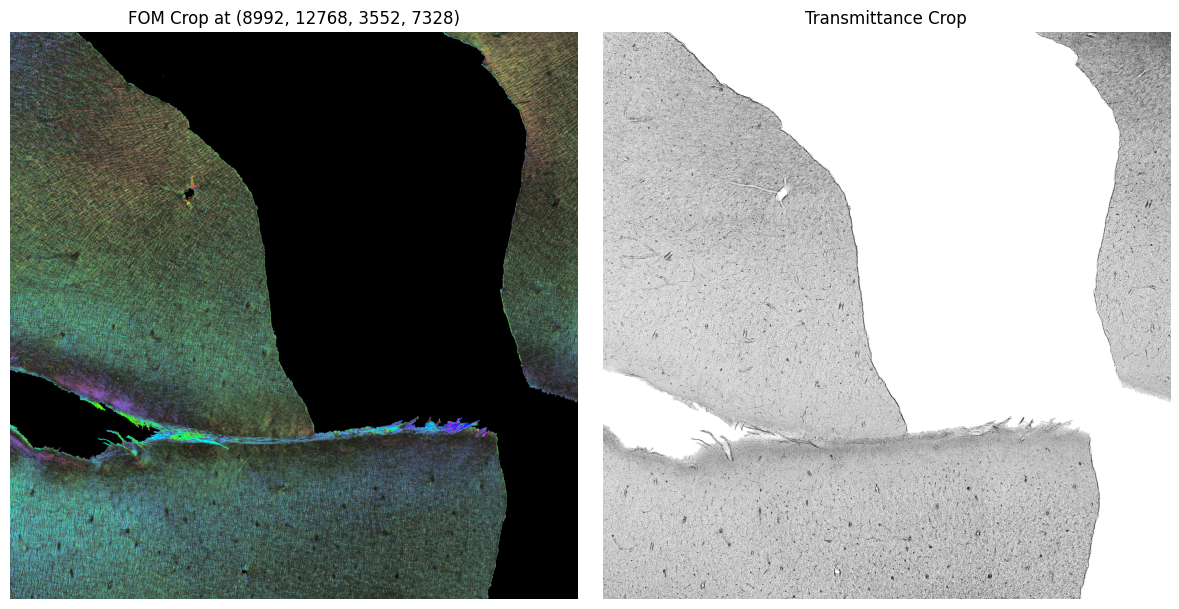

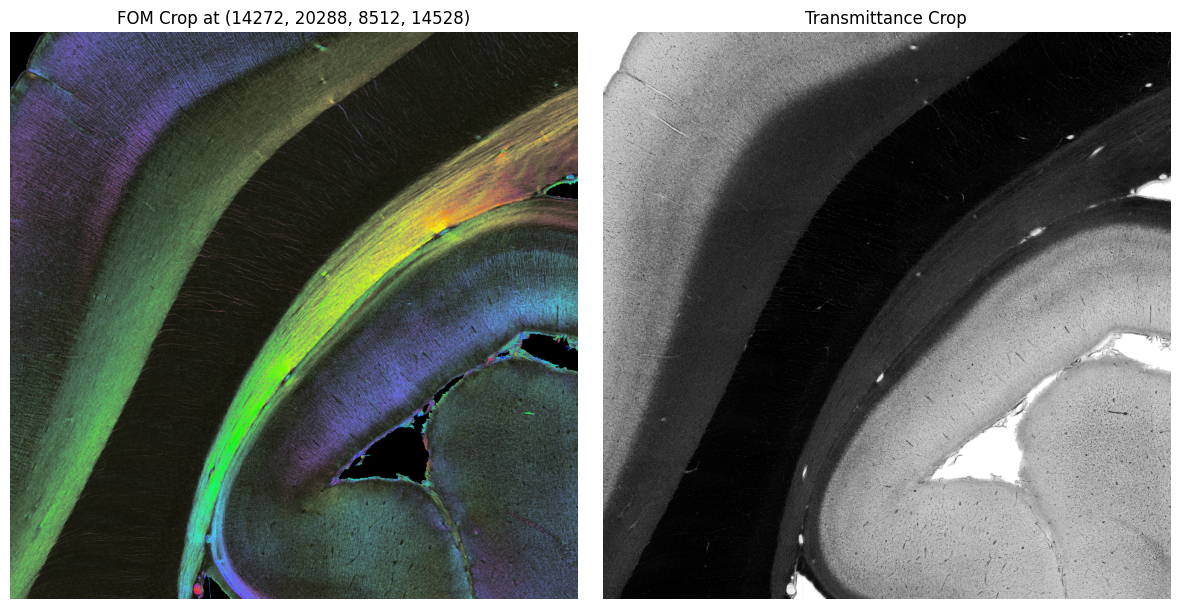

In [10]:
coords = (8992, 12768, 3552, 7328)  # Using coordinates from sliders
view_crop(fom_file, trans_file, coords)
coords_2 = (14272, 20288, 8512, 14528)
view_crop(fom_file, trans_file, coords_2)

We selected an area with different orientations in the colorful FOM to highlight the regions where fiber directions vary significantly.